# Introduction

Fortunately, with libraries such as Scikit-Learn, it’s now easy to build and use almost any machine learning algorithm. But it’s helpful to have an idea of how a machine learning model works under the hood. This lets us diagnose the model when it’s underperforming or explain how it makes decisions, which is crucial if we want to convince others to trust our models.
In this assignment, we’ll look at how to build and use the Decision Tree and the Random Forest in Python. We’ll start by understanding how a single decision tree makes classifications on a simple problem. Then, we’ll work our way to using a random forest on a real-world data science problem.

# Dataset

The dataset we will use in this assignment is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different surfaces. The 60 predictors are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders. There are 208 observations.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the UCI Machine Learning repository.
https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

Download the dataset for free and place it in the "data" folder in your working directory with the filename sonar.all-data.csv.

# Import section

In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

np.random.seed(2020)
random.seed(2020)

# Preprocess data

Read data and convert targets to integers 1 and 0.

In [2]:
PATH = 'data/'
df = pd.read_csv(PATH+'sonar-all-data.csv', header=None)
df.columns = [f'feat_{col}' if col!=60 else 'target' for col in df.columns]
df['target'] = df['target'].map({'M': 1, 'R': 0})
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


# Split data (train and test)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=2020)

# Cost functions

In this section you should implement two cost functions. Any of these can be used in the model.

## Gini index

In [152]:
def gini_index(x):
    """ Calculate Gini Index for a node
    Args:
        x: Numpy-array of targets in a node 
    Returns:
        float: Gini index
    """    
    if len(x) == 0:
        return 0.0
    p = np.bincount(x) / len(x)
    return 1 - np.sum(p*p)

In [153]:
target = df['target'].values
gini_index(target)

0.4977348372781065

In [154]:
def gini_gain(parent_node, splits):
    """ Calculate Gini Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Gini gain
    """       
    splits_gini = np.sum([gini_index(split)*(len(split)/len(parent_node)) for split in splits])
    return gini_index(parent_node) - splits_gini

In [155]:
splits = [np.random.choice(df['target'].values, 100), np.random.choice(df['target'].values, 108)]
gini_gain(target, splits)

0.00937301391628309

## Entropy

In [156]:
def entropy(x):
    """ Calculate Entropy for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Entropy
    """
    if len(x) == 0:
        return 0.0
    p = np.clip(np.bincount(x) / len(x), 1e-15, 1.)
    return -np.sum(p * np.log(p))

In [157]:
def information_gain(parent_node, splits):
    """ Calculate Information Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Information Gain
    """     
    splits_entropy = np.sum([entropy(split)*(len(split)/len(parent_node)) for split in splits])
    return entropy(parent_node) - splits_entropy

# Split function

Implement split functions

In [158]:
def split(X, y, value):
    """ Split y-values in order to calculate gain later
    Args:
        X: 1-dimensional numpy-array of data predictor with shape (N,)
        y: 1-dimensional numpy-array of targets with shape (N,)
        value (float): the value by which the X should be splitted
    Returns:
        Two 1-dimensional numpy-arrays with targets related to splits
    """      
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]


def split_dataset(X, y, column, value):
    """ Split dataset by a particular column and value
    Args:
        X: 2-dimensional numpy-array (N, num_feats). N-number of samples
        y: 1-dimensional numpy-array of targets with shape (N,)  
        column (int): the column by which the X should be splitted
        value (float): the value by which the column should be splitted
    Returns:
        Two 2-dimensional numpy-arrays with data and two 1-dimensional numpy-arrays with targets related to splits
        left_X, right_X, left_y, right_y
    """       
    left_mask = X[:, column] < value
    right_mask = X[:, column] >= value
    left_y, right_y = y[left_mask], y[right_mask]
    left_X, right_X = X[left_mask], X[right_mask]
    return left_X, right_X, left_y, right_y

# Decision tree

In [159]:
class Tree(object):
    """A decision tree classifier.

    Args:
        criterion : {"gini_gain", "information_gain"}
    """
    def __init__(self, criterion=None):
        self.impurity = None
        self.threshold = None
        self.column_index = None
        self.outcome_probs = None
        self.criterion = criterion
        self.left_child = None
        self.right_child = None

    @property
    def is_terminal(self):
        """ Define is it terminal node
        """          
        return not bool(self.left_child and self.right_child)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self.criterion(y, splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    def fit(self, X, y, n_features=None, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
            n_features (int): The number of features when fit is performed (default: all features)
            max_depth (int): The maximum depth of the tree. If None, then nodes are expanded until
                             all leaves are pure.
        """        
        try:
            # Exit from recursion using assert syntax
            if max_depth is not None:
                assert max_depth > 0
                max_depth -= 1

            if n_features is None:
                n_features = X.shape[1]

            column, value, gain = self._find_best_split(X, y, n_features)
            assert gain is not None

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = Tree(self.criterion)
            self.left_child.fit(
                left_X, left_target, n_features, max_depth
            )

            self.right_child = Tree(self.criterion)
            self.right_child.fit(
                right_X, right_target, n_features, max_depth
            )
        except AssertionError:
            self.outcome_probs = np.around(np.sum(y) / y.shape[0])


    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_probs

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

Fit two models with "max_depth=3" and "max_depth=None" hyperparameters. Explain the results.

In [160]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.5476190476190477


In [161]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.5


In [162]:
model = Tree(criterion=information_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.5952380952380952


# Random forest

In [163]:
class RandomForestClassifier(object):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, criterion="entropy", bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        
        if criterion == "entropy":
            self.criterion = information_gain
        elif criterion == "gini":
            self.criterion = gini_gain
        else:
            raise ValueError(f"Unknown criterion '{criterion}'")
            
        self.trees = [Tree(criterion=self.criterion) for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = int(np.sqrt(X.shape[1]))
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            tree.fit(
                X,
                y,
                n_features=self.n_features,
                max_depth=self.max_depth,
            )
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = round(row_pred)
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

Fit two models with "n_estimators=10" and "n_estimators=100" hyperparameters. Explain the results.

In [164]:
model = RandomForestClassifier(n_estimators=10, max_depth=None, n_features=None, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [165]:
model = RandomForestClassifier(n_estimators=100, max_depth=None, n_features=None, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

KeyboardInterrupt: 

Now it's your turn to explore the various parameters of sklearn [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and their influence on model quality.

# Homework part 1. RandomForestClassifier

_Note_: Consider **accuracy** as main metric of model performance on this dataset.

In [15]:
from sklearn.ensemble import RandomForestClassifier

**Task 1 (0.5 points)** Split the dataset into train, test and validation parts (0.6 / 0.2 / 0.2). First two will be used for model hyperparameter tuning whereas the best model quality should be evaluated on validation part.

In [39]:
X, y = df.drop(columns='target'), df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2020)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=2020)

# display(X_train)
# display(X_test)
# display(X_val)

**Task 2 (2 points)**. Apply '_greedy_' hyperparameter tuning of RandomForestClassifier model. '_Greedy_' way means the following general approach. At first we tune one model parameter whereas others are fixed with default values. Then we move on to tune the second parameter whereas others are fixed default values and first has the best values from previous step. After it we tune the third parameter with best fixed values for previous two and default values for the rest. Repeat until we go through all the parameters, then repeat this cycle if you are seeing a clear increase in the test metric. <br>

Although this approach has a lot of disadvantages (you may think which ones), sometimes that is the only way to tune model typerparams due to big training time **if you understand how the model parameters are interrelated and the tuning order takes those dependencies into account.**<br>

Here is one of the possible options for RandomForestClassifier:
- Choose a decent value for number of trees using '_elbow_' rule. You may plot the dependence of accuracy on trees_num and pick up the number after which the error decreases not **as much as before**. 
- Pick up the best split criterion ('gini' / 'entropy') and then tune _max_depth_, _min_samples_split_, _min_samples_leaf_.
- Increase number of trees with best found parameters so far.
- Repeat this excersice starting from picking the best split criterion while other params are fixed with best values from previous steps **if you observe a significant test metric improvement**. Otherwise just stop and measure your best model result on validation set.

score=0.5684088269454124
score=0.6494773519163763
score=0.6682926829268292
score=0.6396051103368177
score=0.6588850174216028
score=0.6637630662020906
score=0.6785133565621371
score=0.6687572590011615
score=0.6687572590011615
score=0.6736353077816493
score=0.6687572590011615
score=0.6735191637630662
score=0.6735191637630662
score=0.6782810685249709


Text(0.5, 1.0, 'score by n_estimators')

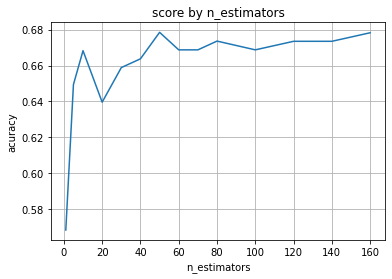

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt

# choose number of trees
n_estimators_list = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 100 , 120, 140, 160]

scores = []
for est in n_estimators_list:
    rfc_model = RandomForestClassifier(n_estimators=est, random_state=15)
    score_list = cross_val_score(rfc_model, X, y, cv=5, scoring='accuracy')
    score = np.mean(score_list)
    
#     rfc_model.fit(X_train, y_train)
#     y_pred = rfc_model.predict(X_test)  
#     # score = mean_squared_error(y_true=y_test, y_pred=y_pred)
#     score = accuracy_score(y_true=y_test, y_pred=y_pred)
    print(f'score={score}')
    scores.append(score)
    
plt.plot(n_estimators_list, scores, label='')
plt.xlabel('n_estimators')
plt.ylabel('acuracy')
plt.grid(True)
plt.title('score by n_estimators')

est = 50



In [57]:
# Pick up the best split criterion ('gini' / 'entropy')
for criteria in ['gini', 'entropy']:
    rfc_model = RandomForestClassifier(n_estimators=est, criterion=criteria, random_state=15)
    score_list = cross_val_score(rfc_model, X, y, cv=5, scoring='accuracy')
    score = np.mean(score_list)
    print(f'score for {criteria}={score}')
    
criteria = 'entropy'

score for gini=0.6782810685249709
score for entropy=0.697444831591173


score=0.7069686411149825
score=0.6826945412311265
score=0.6927990708478513
score=0.6832752613240418
score=0.7072009291521486
score=0.7074332171893147
score=0.6926829268292682
score=0.697444831591173


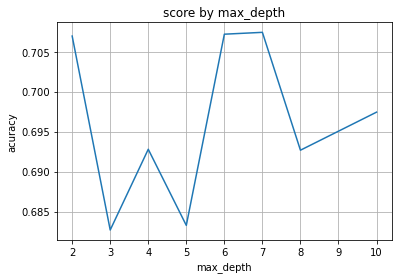

In [61]:
# choose max_depth

max_depth_list = [2, 3, 4, 5, 6, 7, 8, 10]
scores = []
for max_depth in max_depth_list:
    rfc_model = RandomForestClassifier(n_estimators=est, criterion=criteria, max_depth=max_depth, random_state=15)
    score_list = cross_val_score(rfc_model, X, y, cv=5, scoring='accuracy')
    score = np.mean(score_list)
    
#     rfc_model.fit(X_train, y_train)
#     y_pred = rfc_model.predict(X_test)  
#     # score = mean_squared_error(y_true=y_test, y_pred=y_pred)
#     score = accuracy_score(y_true=y_test, y_pred=y_pred)
    print(f'score={score}')
    scores.append(score)
    
plt.plot(max_depth_list, scores, label='')
plt.xlabel('max_depth')
plt.ylabel('acuracy')
plt.grid(True)
plt.title('score by max_depth')    

max_depth = 7

score=0.6832752613240418
score=0.6832752613240418
score=0.6880371660859466
score=0.697560975609756
score=0.6638792102206736
score=0.7073170731707317
score=0.7169570267131242
score=0.5336817653890825
score=0.5336817653890825


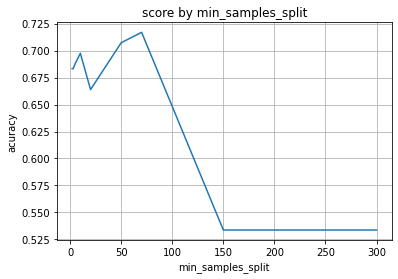

In [65]:
# choose min_samples_split

min_samples_split_list = [2, 3, 5 , 10, 20 , 50, 70, 150, 300]
scores = []
for min_samples_split in min_samples_split_list:
    rfc_model = RandomForestClassifier(n_estimators=est, criterion=criteria, max_depth=max_depth, min_samples_split=min_samples_split, random_state=15)
    score_list = cross_val_score(rfc_model, X, y, cv=5, scoring='accuracy')
    score = np.mean(score_list)
    
#     rfc_model.fit(X_train, y_train)
#     y_pred = rfc_model.predict(X_test)  
#     # score = mean_squared_error(y_true=y_test, y_pred=y_pred)
#     score = accuracy_score(y_true=y_test, y_pred=y_pred)
    print(f'score={score}')
    scores.append(score)
    
plt.plot(min_samples_split_list, scores, label='')
plt.xlabel('min_samples_split')
plt.ylabel('acuracy')
plt.grid(True)
plt.title('score by min_samples_split')    

min_samples_split = 70

score=0.7022067363530777
score=0.6926829268292682
score=0.7024390243902439
score=0.6878048780487804
score=0.6588850174216028


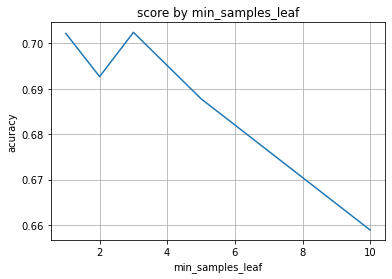

In [74]:
# choose min_samples_leaf

min_samples_leaf_list = [1, 2, 3, 5, 10]
scores = []
for min_samples_leaf in min_samples_leaf_list:
    rfc_model = RandomForestClassifier(n_estimators=est, criterion=criteria, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=15)
    score_list = cross_val_score(rfc_model, X, y, cv=5, scoring='accuracy')
    score = np.mean(score_list)
    print(f'score={score}')
    scores.append(score)
    
plt.plot(min_samples_leaf_list, scores, label='')
plt.xlabel('min_samples_leaf')
plt.ylabel('acuracy')
plt.grid(True)
plt.title('score by min_samples_leaf')    

min_samples_leaf = 3

score=0.548548199767712
score=0.6824622531939606
score=0.7022067363530777
score=0.721486643437863
score=0.697560975609756
score=0.6880371660859466
score=0.7024390243902439
score=0.6976771196283391
score=0.7170731707317073
score=0.7075493612078978
score=0.6833914053426249
score=0.6931475029036005
score=0.6929152148664344
score=0.7073170731707317


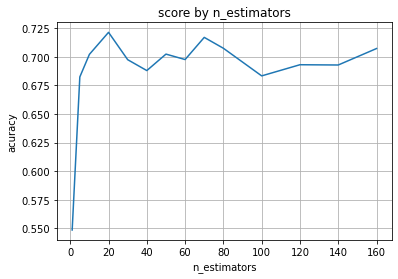

In [77]:
# choose number of trees
n_estimators_list = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 100 , 120, 140, 160]

scores = []
for est in n_estimators_list:
    rfc_model = RandomForestClassifier(n_estimators=est, criterion=criteria, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=15)
    score_list = cross_val_score(rfc_model, X, y, cv=5, scoring='accuracy')
    score = np.mean(score_list)
    
#     rfc_model.fit(X_train, y_train)
#     y_pred = rfc_model.predict(X_test)  
#     # score = mean_squared_error(y_true=y_test, y_pred=y_pred)
#     score = accuracy_score(y_true=y_test, y_pred=y_pred)
    print(f'score={score}')
    scores.append(score)
    
plt.plot(n_estimators_list, scores, label='')
plt.xlabel('n_estimators')
plt.ylabel('acuracy')
plt.grid(True)
plt.title('score by n_estimators')

est = 20

In [115]:
clf = RandomForestClassifier(n_estimators=est, criterion=criteria, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=15)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f'accuracy={accuracy_score(y_test, y_pred)}')

accuracy=0.6904761904761905


**Итого:**
    score=0.6904761904761905

    n_estimators = 20
    
    criterion= 'entropy'
    
    max_depth = 7
    
    min_samples_split = 70
    
    min_samples_leaf = 3

### Grid Search and Random Search

If you have enough computational power for model training in a reasonable amount of time more sophisticated approach of hyperparameter tuning would be either Grid Search or Random Search.<br>

In a nutshell Grid Search allows you to pass through all different combinations of given model parameters and their values and choose the best combination. Whereas Random Search would randomly choose values for given model parameters and evaluate them on test data untill it reaches the specified number of iterations.<br>

More information here [Gentle introduction to Grid and Random search](https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318) and here [Detailed Explanation with code examples](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/).

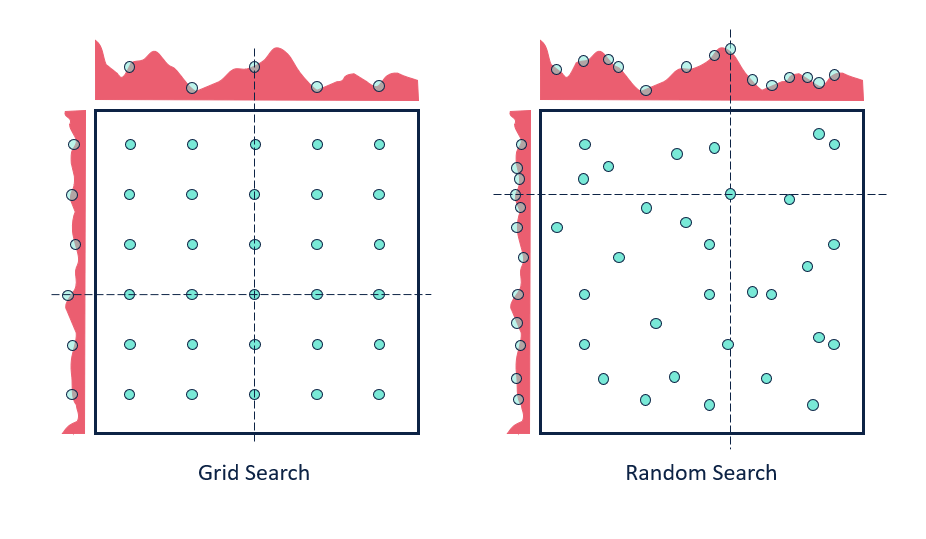

**Task 3 (1 point)**. Compare your previous results with [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) hyperparameter tuning. You may tune best hyperparameters for forest with several trees and then increase it while measure the quality on validation dataset.

In [105]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_estimators': [1, 20, 40, 50, 60, 70, 80, 100, ],
    'min_samples_split': [2, 3, 5 , 10, 20 , 50, 70, 150],
    'min_samples_leaf': [1, 2, 3, 5,],
    'max_depth' : [2, 3, 5, 6, 7, 10],
    'criterion' :['gini', 'entropy']
}
rfc_main_model = RandomForestClassifier(random_state=15)

clf = GridSearchCV(rfc_main_model, param_grid, scoring='accuracy', )
                   # verbose=4)
clf.fit(X_train, y_train)
best_clf = clf.best_estimator_ 

n_estimators_r = clf.cv_results_['params'][clf.best_index_]['n_estimators']
min_samples_split_r = clf.cv_results_['params'][clf.best_index_]['min_samples_split']
min_samples_leaf_r = clf.cv_results_['params'][clf.best_index_]['min_samples_leaf']
max_depth_r = clf.cv_results_['params'][clf.best_index_]['max_depth']
criterion_r = clf.cv_results_['params'][clf.best_index_]['criterion']

print(f'n_estimators={n_estimators_r}\n')
print(f'min_samples_split={min_samples_split_r}\n')
print(f'min_samples_leaf={min_samples_leaf_r}\n')
print(f'max_depth={max_depth_r}\n')
print(f'criterion={criterion_r}\n')


y_pred = best_clf.predict(X_test)
print(f'accuracy={accuracy_score(y_test, y_pred)}')


n_estimators=100

min_samples_split=3

min_samples_leaf=1

max_depth=7

criterion=entropy

accuracy=0.6904761904761905


**Task 4 (1 point)**. And finally tune forest hyperparameters with [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Compare results to previous attempts.

In [113]:
from scipy.stats import uniform, truncnorm, randint
from sklearn.model_selection import RandomizedSearchCV
    
param_grid = { 
    'n_estimators': randint(1,200), 
    'min_samples_split':  randint(2,300),
    'min_samples_leaf':  randint(1,20),
    'max_depth' :  randint(2,20),
    'criterion' :['gini', 'entropy']
}
rfc_main_model = RandomForestClassifier(random_state=15)

clf = RandomizedSearchCV(rfc_main_model, param_grid, scoring='accuracy', n_iter=30, random_state=25)
                   # verbose=4)
clf.fit(X_train, y_train)
best_clf = clf.best_estimator_ 


n_estimators_r = clf.cv_results_['params'][clf.best_index_]['n_estimators']
min_samples_split_r = clf.cv_results_['params'][clf.best_index_]['min_samples_split']
min_samples_leaf_r = clf.cv_results_['params'][clf.best_index_]['min_samples_leaf']
max_depth_r = clf.cv_results_['params'][clf.best_index_]['max_depth']
criterion_r = clf.cv_results_['params'][clf.best_index_]['criterion']

print(f'n_estimators={n_estimators_r}\n')
print(f'min_samples_split={min_samples_split_r}\n')
print(f'min_samples_leaf={min_samples_leaf_r}\n')
print(f'max_depth={max_depth_r}\n')
print(f'criterion={criterion_r}\n')


y_pred = best_clf.predict(X_test)
print(f'accuracy={accuracy_score(y_test, y_pred)}')



n_estimators=166

min_samples_split=16

min_samples_leaf=18

max_depth=12

criterion=entropy

accuracy=0.6666666666666666


**Task 5 (0.5 points)**. Tell us about your experience in hyperparameter tuning with the approaches above. What do you think would be the best option for this task and why?

**"Жадный алгоритм"** обеспечивает относительно оптимальный подбор парметров за отностильно не большой промежеток времениЮ но требует большое количество ручной работы.

**GridSearchCV** обеспечивает самый точный подбор параметров (при подборе только категориальных парметров) за условно длительный промежуток времени (т.к. исрозуется перебор всех параметров), требует больших вычислительных мощностей

**RandomizedSearchCV** обеспечивает оптимальный подбор парметров за отностильно небольшой промежуток времени (не требует больших вычислительных мощностей), при подборе некатегориальных парметров может обеспечивать даже более оптимальный подбор параметров чем GridSearchCV.


В данном случае "Жадный алгоритм" оказался аналогичен по эффективности GridSearchCV, но для  "Жадного алгоритма" пришлось провести большое количество ручной работы. 
RandomizedSearchCV может подойти для быстрого прототипирования


### Desicion tree explained

Remember the [Titanic](https://www.kaggle.com/c/titanic) competition from last week? Wouldn't be a good idea to visualize one of possible desicion-making processes of _survived_ / _dead_ labeling?

**Task 6 (1 point)**. Load titanic dataset, split it into train/test parts, apply simple hyperparameter tuning of [DesicionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (use one of the approaches above) in order to have **test accuracy more than 0.65**. <br>

Draw the best tree decision making process. You may use [sklearn.tree.prot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).<br>

In [117]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [120]:
np.random.seed(31415)


PATH = "./data/"
titanic_data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
titanic_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [122]:
    
X, y = titanic_data.drop(columns='Survived'), titanic_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2020)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=2020)

# display(X_train)
# display(X_test)
# display(X_val)    


In [125]:
def missing_values_preprocessing(original_data, inplace=False):
    if inplace:
        ret_data = original_data
    else:
        ret_data = original_data.copy()
    ret_data['Age'].fillna(ret_data['Age'].median(), inplace=True)
    ret_data['Embarked'].fillna(ret_data['Embarked'].mode(), inplace=True)
    ret_data['Fare'].fillna(ret_data['Fare'].median(), inplace=True)

    ret_data['Cabin_b'] = ret_data.apply(lambda row: 1 if pd.notnull(row['Cabin'])  else 0, axis=1)
    # change NaN to 'Z'
    # ret_data['Cabin'].fillna('Z', inplace=True)
    # extract letter from Cabin
    # ret_data['Cabin_letter'] = ret_data['Cabin'].str.extract(r'([A-Z]).*')
    return ret_data

def drop_columns(original_data):
    return original_data.drop(columns=['Cabin', 'Name', 'Ticket', 'Age'], axis=1)

def categorical_features_encoding(original_data):
    ret_data = pd.get_dummies(data=original_data, columns=["Sex"], drop_first=True, )
    ret_data = pd.get_dummies(data=ret_data, columns=["Embarked"],drop_first=True)
    # ret_data = pd.get_dummies(data=ret_data, columns=["Cabin_letter"], drop_first=True)
    return ret_data

In [128]:
preprecessed_data = missing_values_preprocessing(X_train)
preprecessed_data = categorical_features_encoding(preprecessed_data)
preprecessed_data = drop_columns(preprecessed_data)


In [143]:
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import uniform, truncnorm, randint
from sklearn.model_selection import RandomizedSearchCV


   
param_grid = { 
    'min_samples_split':  randint(2,300),
    'min_samples_leaf':  randint(1,20),
    'max_depth' :  randint(2,20),
    'criterion' :['gini', 'entropy']
}
dtc_model = DecisionTreeClassifier(random_state=15)

clf = RandomizedSearchCV(dtc_model, param_grid, scoring='accuracy', n_iter=30, random_state=25)
                   # verbose=4)
clf.fit(preprecessed_data, y_train)
best_clf = clf.best_estimator_ 


min_samples_split_r = clf.cv_results_['params'][clf.best_index_]['min_samples_split']
min_samples_leaf_r = clf.cv_results_['params'][clf.best_index_]['min_samples_leaf']
max_depth_r = clf.cv_results_['params'][clf.best_index_]['max_depth']
criterion_r = clf.cv_results_['params'][clf.best_index_]['criterion']

print(f'min_samples_split={min_samples_split_r}\n')
print(f'min_samples_leaf={min_samples_leaf_r}\n')
print(f'max_depth={max_depth_r}\n')
print(f'criterion={criterion_r}\n')


preprecessed_test = missing_values_preprocessing(X_test)
preprecessed_test = categorical_features_encoding(preprecessed_test)
preprecessed_test = drop_columns(preprecessed_test)
display(preprecessed_test)
y_pred = best_clf.predict(preprecessed_test)

print(f'accuracy={accuracy_score(y_test, y_pred)}')

min_samples_split=52

min_samples_leaf=14

max_depth=14

criterion=gini



,Pclass,SibSp,Parch,Fare,Cabin_b,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,
193,3,1,0,7.8542,0,0,0,1
249,1,1,1,52.5542,1,1,0,1
709,1,0,0,151.5500,0,0,0,1
110,3,1,0,24.1500,0,0,1,0
35,1,1,0,82.1708,0,1,0,0
...,...,...,...,...,...,...,...,...
350,3,0,0,8.6625,0,1,0,1
436,1,1,2,120.0000,1,0,0,1
726,3,0,0,8.6625,0,1,0,1


accuracy=0.7696629213483146


[Text(571.9499999999999, 616.08, 'X[5] <= 0.5\ngini = 0.462\nsamples = 534\nvalue = [341, 193]'),
 Text(279.0, 543.6, 'X[0] <= 2.5\ngini = 0.396\nsamples = 184\nvalue = [50, 134]'),
 Text(111.6, 471.12, 'X[3] <= 28.856\ngini = 0.094\nsamples = 101\nvalue = [5, 96]'),
 Text(55.8, 398.64000000000004, 'gini = 0.172\nsamples = 42\nvalue = [4, 38]'),
 Text(167.39999999999998, 398.64000000000004, 'X[3] <= 134.075\ngini = 0.033\nsamples = 59\nvalue = [1, 58]'),
 Text(111.6, 326.16, 'gini = 0.0\nsamples = 45\nvalue = [0, 45]'),
 Text(223.2, 326.16, 'gini = 0.133\nsamples = 14\nvalue = [1, 13]'),
 Text(446.4, 471.12, 'X[3] <= 22.904\ngini = 0.496\nsamples = 83\nvalue = [45, 38]'),
 Text(390.59999999999997, 398.64000000000004, 'X[7] <= 0.5\ngini = 0.495\nsamples = 67\nvalue = [30, 37]'),
 Text(334.79999999999995, 326.16, 'gini = 0.4\nsamples = 29\nvalue = [8, 21]'),
 Text(446.4, 326.16, 'gini = 0.488\nsamples = 38\nvalue = [22, 16]'),
 Text(502.2, 398.64000000000004, 'gini = 0.117\nsamples = 16\

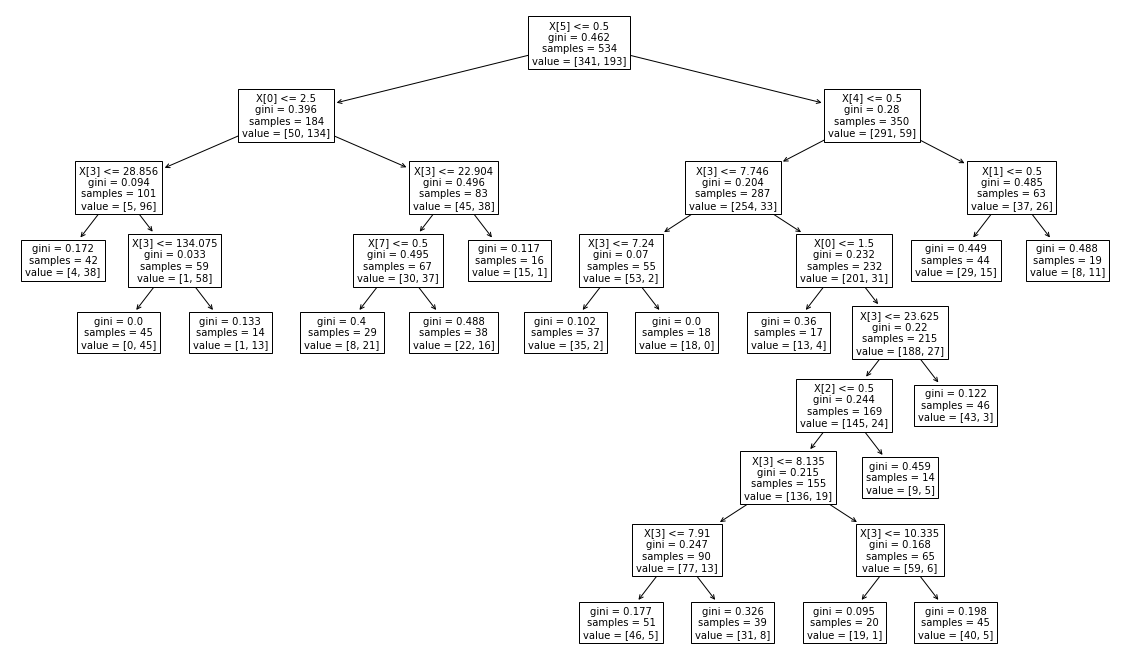

In [142]:
from sklearn import tree
plt.figure(figsize=(20,12))
tree.plot_tree(best_clf, fontsize=10) 

Is it easy to interpret its results? Are you able to explain to a random person why would he survive / die on the titanic?

**Интерпритаци**:
в корневом узле идет разделение по полу (X\[5\] <= 0.5, X\[5\] - Sex_male), в левой ветке женщины, в правой - мужчины. Идем налево, женщины делятся по классу (X\[0\] <= 2.5) - слева все выше 3-го класса, справа  - 3-тий класс. Идем на лево, разделение по доходам (Fare) (X\[3\] <= 28.856), налево у кого меньше 28.856, нарправо больше. Идем налево, все кто попал сюда - считаются выжившими.

# Homework part 2. RandomForestRegressor

**Task 7 (2 points)**. Write your own *DecisionTreeRegressor* class with _MSE_ split criterion and settable parameter *max_depth*. Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). <br>

Provide examples for different _max_depth_ parameter.

Of course you may re-use code for *DecisionTreeClassifier*. You need to figure out what needs to be changed in it for Classification -> Regression transformation.<br>

**! You are allowed to use only NumPy library** in this assigment.

In [17]:
import numpy as np

def f(X):
    return X[:, 0]**3 + np.log(np.exp(X[:, 1]) + np.exp(X[:, 2])) + np.sqrt(abs(X[:, 3])) * X[:, 4]

n_samples = 100

stdv = 1. / np.sqrt(5)

X = np.random.uniform(-stdv, stdv, size = (n_samples, 5))
y = f(X)

In [20]:
# Your code here

**Task 8 (2 points)**. Write your own _RandomForestRegressor_ class with MSE split criterion and settable parameter _max_depth_.  Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).<br>

Provide examples for different max_depth parameter.<br>

**! You are allowed to use only NumPy library** in this assigment.

In [21]:
# Your code here

# Homework part 3 (bonus). Speeding up forest training process

**Task 9 (3 points)** Devise a way to speed up training against the default version of our custom _RandomForestClassifier_ or your own _RandomForestRegressor_. You may want use [`joblib`](https://joblib.readthedocs.io/en/latest/) for parallelizing trees training. Provide graphs of time dependences on the number of trees in your _fast_ version with different number of cores / threads used against default one.

In [264]:
from math import sqrt


In [265]:
from joblib import Parallel, delayed

class RandomForestClassifierF(object):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, criterion="entropy", bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        
        if criterion == "entropy":
            self.criterion = information_gain
        elif criterion == "gini":
            self.criterion = gini_gain
        else:
            raise ValueError(f"Unknown criterion '{criterion}'")
            
        self.trees = [Tree(criterion=self.criterion) for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    def worker(self, i):
        if self.bootstrap:
            idxs = self.bootstrap_data(self.size)
            X = self.X[idxs]
            y = self.y[idxs]
        else:
            X = self.X
            y = self.y
        tree = self.trees[i]
        tree.fit(
            X,
            y,
            n_features=self.n_features,
            max_depth=self.max_depth, 
        )
           
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """                    
        
        if self.n_features is None:
            self.n_features = int(np.sqrt(X.shape[1]))
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
                
        n_estimators = self.n_estimators
        Parallel(n_jobs=n_estimators, require='sharedmem')(delayed(self.worker)(i) for i in range(n_estimators))      
                            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = round(row_pred)
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")
            

In [269]:
X, y = df.drop(columns='target'), df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2020)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=2020)

# display(X_train)
# display(X_test)
# display(X_val)

rfcf_model = RandomForestClassifierF(n_estimators=5, bootstrap=False)
rfcf_model.fit(X_train, y_train)
print(rfcf_model.trees)

y_pred = rfcf_model.predict(X_test)

print(f'accuracy={accuracy_score(y_test, y_pred)}')

[<__main__.Tree object at 0x000002121E518190>, <__main__.Tree object at 0x000002121E518E80>, <__main__.Tree object at 0x000002121E518220>, <__main__.Tree object at 0x000002121E5187F0>, <__main__.Tree object at 0x000002121E87D8B0>]
accuracy=0.5952380952380952


**С увеличением числа ядер время уменшяется**